In [1]:
# https://www.kaggle.com/code/arunponnusamy/generating-handwritten-digits-with-dcgan

In [2]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2DTranspose
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras.optimizers import Adam

2025-05-15 21:05:09.013827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747323309.031310  213627 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747323309.036397  213627 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-15 21:05:09.054877: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class DCGAN:
    @staticmethod
    def build_generator(dim, depth, channels=1, inputDim=100, outputDim=512):

        model = Sequential()

        inputShape = (dim, dim, depth)
        chanDim = -1


        model.add(Dense(units=outputDim, input_dim=inputDim))
        model.add(Activation("relu"))
        model.add(BatchNormalization())

        model.add(Dense(dim * dim * depth))
        model.add(Activation("relu"))
        model.add(BatchNormalization())

        model.add(Reshape(inputShape))
        model.add(Conv2DTranspose(32, (5,5), strides=(2,2), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))

        model.add(Conv2DTranspose(channels, (5,5), strides=(2,2), padding="same"))
        model.add(Activation("tanh"))

        return model

    @staticmethod
    def build_discriminator(width, height, depth, alpha=0.2):

        model = Sequential()
        inputShape = (height, width, depth)

        model.add(Conv2D(32, (5,5), padding="same", strides=(2,2),
                    input_shape=inputShape))
        model.add(LeakyReLU(alpha=alpha))


        model.add(Conv2D(64, (5,5), padding="same", strides=(2,2)))
        model.add(LeakyReLU(alpha=alpha))

        model.add(Flatten())
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=alpha))

        model.add(Dense(1))
        model.add(Activation("sigmoid"))

        return model

In [4]:
#!pip install imutils

In [7]:
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from keras.datasets import mnist
from sklearn.utils import shuffle
from imutils import build_montages
import numpy as np
import argparse
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
trainImages = np.concatenate([trainX, testX])

print(trainX.shape)
print(trainImages.shape)

trainImages = np.expand_dims(trainImages, axis=-1)
trainImages = (trainImages.astype("float") - 127.5) / 127.5

[INFO] loading MNIST dataset...
(60000, 28, 28)
(70000, 28, 28)


In [9]:
print("[INFO] building generator...")
gen = DCGAN.build_generator(7, 64)

[INFO] building generator...


/store/venv/da5401/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747323395.727586  213627 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7925 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1


In [10]:
print("[INFO] building discriminator...")
disc = DCGAN.build_discriminator(28, 28, 1)
discOpt = Adam(learning_rate=0.0002, beta_1=0.5, decay=0.0002 / NUM_EPOCHS)
disc.compile(loss="binary_crossentropy", optimizer=discOpt)

[INFO] building discriminator...


/store/venv/da5401/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/store/venv/da5401/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/store/venv/da5401/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [11]:
print("[INFO] building GAN...")
disc.trainable = False
ganInput = Input(shape=(100,))
ganOutput = disc(gen(ganInput))
gan = Model(ganInput, ganOutput)

print(gan.summary())

ganOpt = Adam(learning_rate=0.0002, beta_1=0.5, decay=0.0002 / NUM_EPOCHS)
gan.compile(loss="binary_crossentropy", optimizer=discOpt)

[INFO] building GAN...


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 28, 28, 1)      │     1,727,233 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │     1,658,753 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,385,986 (12.92 MB)

 Trainable params: 1,719,873 (6.56 MB)

 Non-trainable params: 1,666,113 (6.36 MB)

None


In [12]:
print("[INFO] starting training...")
benchmarkNoise = np.random.uniform(-1, 1, size=(256, 100))
output_dir = os.getcwd()

for epoch in range(NUM_EPOCHS):

    print("[INFO] starting epoch {} of {}...".format(epoch + 1, NUM_EPOCHS))
    batchesPerEpoch = int(trainImages.shape[0] / BATCH_SIZE)

    for i in range(0, batchesPerEpoch):

        p = None

        imageBatch = trainImages[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
        noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))

        genImages = gen.predict(noise, verbose=0)

        X = np.concatenate((imageBatch, genImages))
        y = np.array(([1] * BATCH_SIZE) + ([0] * BATCH_SIZE))
        (X, y) = shuffle(X, y)

        discLoss = disc.train_on_batch(X, y)

        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        ganLoss = gan.train_on_batch(noise, np.array([1] * BATCH_SIZE))

        if i == batchesPerEpoch - 1:
            p = [output_dir, "epoch_{}_output.png".format(str(epoch + 1).zfill(4))]

        if p is not None:
            #print("[INFO] Step {}_{}: discriminator_loss={:.6f}, "
            #    "adversarial_loss={:.6f}".format(epoch+1, i, discLoss, ganLoss))
            print(f"[INFO] Step {epoch+1}_{i}: Discr loss={discLoss}, Adv loss={ganLoss}")
            images = gen.predict(benchmarkNoise)
            images = ((images * 127.5) + 127.5).astype("uint8")
            images = np.repeat(images, 3, axis=-1)
            vis = build_montages(images, (28,28), (16,16))[0]

            p = os.path.sep.join(p)
            cv2.imwrite(p, vis)

[INFO] starting training...
[INFO] starting epoch 1 of 10...


I0000 00:00:1747323418.614270  214619 service.cc:148] XLA service 0x7d9c080037d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747323418.614296  214619 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-05-15 21:06:58.621111: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747323418.648728  214619 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747323419.026895  214619 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/store/venv/da5401/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


[INFO] Step 1_545: Discr loss=1.0083411931991577, Adv loss=[array(1.0083412, dtype=float32), array(1.0083412, dtype=float32)]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
[INFO] starting epoch 2 of 10...


KeyboardInterrupt: 

In [ ]:
!ls

sample_data


TypeError: Image data of dtype object cannot be converted to float

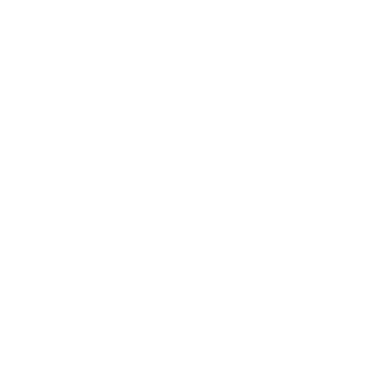

In [ ]:
out = cv2.imread("epoch_0001_output.png")
plt.axis("off")
plt.imshow(out)

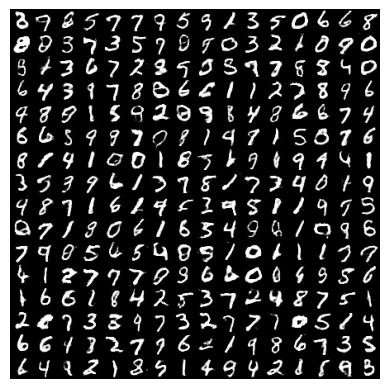

In [ ]:
out = cv2.imread("epoch_0010_output.png")
plt.axis("off")
plt.imshow(out)